# Drake Quad PID

In [1]:
import math
import pydot
import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import HTML, display, SVG
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    RobotDiagramBuilder,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    WrapToSystem,
    namedview,
)
from pydrake.examples import (
    AcrobotGeometry,
    AcrobotInput,
    AcrobotPlant,
    AcrobotState,
    QuadrotorGeometry,
    QuadrotorPlant,
    StabilizingLQRController,
)
from pydrake.solvers import MathematicalProgram, Solve
import os
from underactuated import ConfigureParser, running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer
from underactuated.scenarios import AddFloatingRpyJoint
from pydrake.multibody.tree import QuaternionFloatingJoint
if running_as_notebook:
    mpld3.enable_notebook()

/home/vince-cs/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Visualization Server

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


## Make Multibody plant

We use the drake library to import our quad rotor without the propellers. This maintains its inertial properties and mass properties from the urdf file specified.

<img src="images/quad_arm.png" alt="Alt text" width="600"/>

Arm length measurement

In [3]:

def MakeMultibodyQuadrotor():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)
    #plant = builder.AddSystem(MultibodyPlant(0.0))
    #scene_graph = builder.AddSystem(SceneGraph())
    parser = Parser(plant)
    
    # Your relative path
    relative_path = "quad-v4/quad-v4.urdf"
    # Convert to an absolute path
    absolute_path = os.path.abspath(relative_path)
    
    # Use the absolute path here
    (model_instance,) = parser.AddModels(absolute_path)
    
    # Adding QuaternionFloatingJoint
    frame_on_parent = plant.world_frame()
    frame_on_child = plant.GetFrameByName("quad_v4", model_instance)
    plant.AddJoint(
        QuaternionFloatingJoint(
            name="BaseJoint",
            frame_on_parent=frame_on_parent,  # Corrected parameter name
            frame_on_child=frame_on_child,  # Corrected parameter name
            angular_damping=0.0,  # Optional, showing how to use it
            translational_damping=0.0  # Optional, showing how to use it
        )
    )
    plant.Finalize()

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, scene_graph, meshcat
    )

    body_index = plant.GetBodyByName("quad_v4").index()

    L = 0.395 #meters arm length
    #prop_offsets = [0.21507, 0.27856, 0.09495]
    prop_pos = {'x' : 0.21507, 'y' : 0.27856, 'z' : 0.09495}
    kF = 1.0 #0.77 #estimate thrust constant (thrust = kF * angularvelocity^2)
    kM = 1 #estimate torque constant (torque = kM * angularvelocity^2)

    """
    prop_info = [
        PropellerInfo(body_index, RigidTransform([L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, L, 0]), kF, -kM),
        PropellerInfo(body_index, RigidTransform([-L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, -L, 0]), kF, -kM),
    ]
    """

    prop_info = [
        PropellerInfo(body_index, RigidTransform([-prop_pos['x'], -prop_pos['y'], prop_pos['z']]), kF, kM), #CW
        PropellerInfo(body_index, RigidTransform([prop_pos['x'], -prop_pos['y'], prop_pos['z']]), kF, -kM), #CCW
        PropellerInfo(body_index, RigidTransform([prop_pos['x'], prop_pos['y'], prop_pos['z']]), kF, kM), #CW
        PropellerInfo(body_index, RigidTransform([-prop_pos['x'], prop_pos['y'], prop_pos['z']]), kF, -kM), #CCW
    ]
    propellers = builder.AddSystem(Propeller(prop_info))
    builder.Connect(
        propellers.get_output_port(),
        plant.get_applied_spatial_force_input_port(),
    )
    builder.Connect(
        plant.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )

    #quad_base = plant.GetModelInstanceByName("body")
    builder.ExportInput(propellers.get_command_input_port(), "u")
    builder.ExportOutput(plant.get_state_output_port(), "state")


    return builder.Build(), plant


In [4]:
quadrotor_system, quadrotor_plant = MakeMultibodyQuadrotor()

quadrotor_plant.set_name("quadrotor_base")

quadrotor_system.set_name("quadrotor_system")

### Viewing the plant diagram (no propeller dynamics)

Here we can view the different ports of our imported robot. There are two main types of ports, input ports, and output ports. Input ports are typically for input actuations, output ports are typically for state information such as position velocity and attitude.

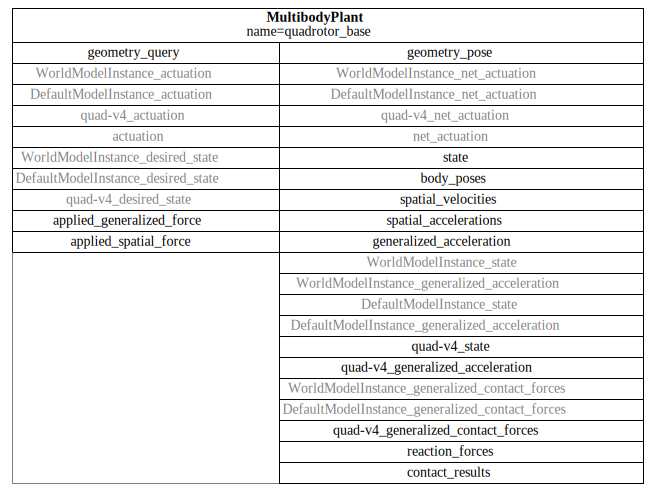

In [5]:
display(
    SVG(
        pydot.graph_from_dot_data(
            quadrotor_plant.GetGraphvizString(
                max_depth=3))[0].create_svg()))

### Printing information of plant (no propellers)

In [6]:
# First, ensure your MultibodyPlant 'mbp' is properly initialized and finalized
# as shown in your MakeMultibodyQuadrotor() function
from pydrake.multibody.tree import BodyIndex, JointIndex

# Information about states and elements
num_positions = quadrotor_plant.num_positions()
num_velocities = quadrotor_plant.num_velocities()
num_multibody_states = quadrotor_plant.num_multibody_states()
num_actuators = quadrotor_plant.num_actuators()  # Corrected from num_force_elements to num_actuators for clarity
num_force_elements = quadrotor_plant.num_force_elements()
num_bodies = quadrotor_plant.num_bodies()
num_joints = quadrotor_plant.num_joints()
num_model_instances = quadrotor_plant.num_model_instances()

# Printing the collected information
print(f"Number of position states: {num_positions}")
print(f"Number of velocity states: {num_velocities}")
print(f"Total number of multibody states: {num_multibody_states}")
print(f"Total number of force elements: {num_force_elements}")
print(f"Total number of bodies: {num_bodies}")
print(f"Number of joints: {num_joints}")
print(f"Number of model instances: {num_model_instances}")

# Additional useful information might include details about specific components, like joints and bodies.
# Here's how you could list the names of all bodies and joints in the MultibodyPlant:
print("\nList of all body names:")
for i in range(quadrotor_plant.num_bodies()):
    body = quadrotor_plant.get_body(BodyIndex(i))
    print(f"Body {i}: {body.name()}")
    print("---------------------------------------------")

print("\nList of all joint names:")
for i in range(quadrotor_plant.num_joints()):
    joint = quadrotor_plant.get_joint(JointIndex(i))
    print(f"Joint {i}: {joint.name()}")

print("\nPosition Names")
for name in quadrotor_plant.GetPositionNames():
    print(name)

print("\nVelocity Names")
for name in quadrotor_plant.GetVelocityNames():
    print(name)


print("\nState Names")
for name in quadrotor_plant.GetStateNames():
    print(name)

Number of position states: 7
Number of velocity states: 6
Total number of multibody states: 13
Total number of force elements: 1
Total number of bodies: 7
Number of joints: 6
Number of model instances: 3

List of all body names:
Body 0: world
---------------------------------------------
Body 1: CCW_Prop_3
---------------------------------------------
Body 2: CW_Prop1
---------------------------------------------
Body 3: Prop_4_CCW
---------------------------------------------
Body 4: quad_v4
---------------------------------------------
Body 5: quad_v4_Payload
---------------------------------------------
Body 6: quad_v4_Prop_2_CW
---------------------------------------------

List of all joint names:
Joint 0: CCW_Prop_4
Joint 1: Prop1_CW
Joint 2: Prop_3_CCW
Joint 3: base_link_Payload
Joint 4: base_link_Prop_2_CW
Joint 5: BaseJoint

Position Names
quad-v4_BaseJoint_qw
quad-v4_BaseJoint_qx
quad-v4_BaseJoint_qy
quad-v4_BaseJoint_qz
quad-v4_BaseJoint_x
quad-v4_BaseJoint_y
quad-v4_BaseJoi

### Viewing diagram of whole quadrotor system (with propellers and defined input output ports)

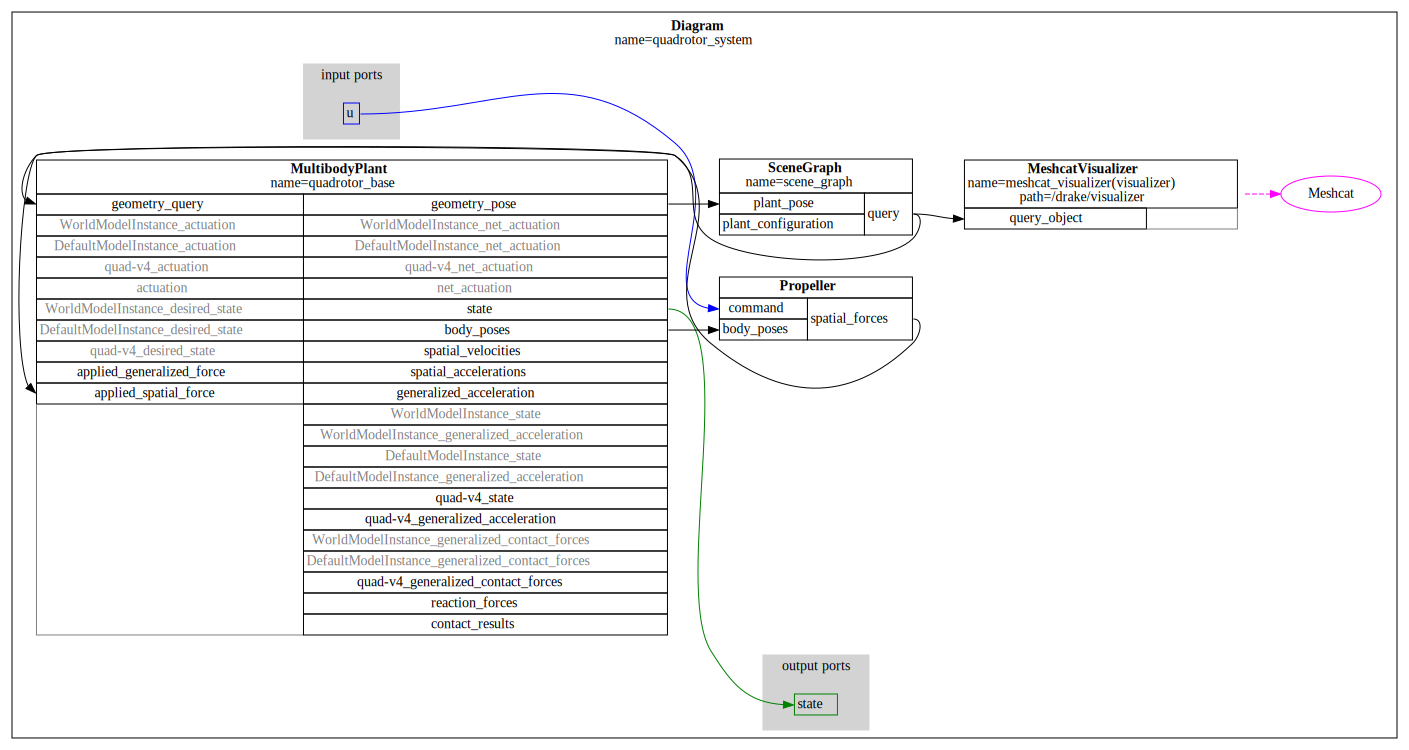

In [7]:
display(
    SVG(
        pydot.graph_from_dot_data(
            quadrotor_system.GetGraphvizString(
                max_depth=3))[0].create_svg()))

### Printing Input output port information

In [8]:
# Print information about input ports
print("Input Ports (Thrust commands)")
print(f"N input ports : {quadrotor_system.num_input_ports()}")
print(f"Actuation port size {quadrotor_system.get_input_port(0).size()} [u_1, u_2, u_3, u_4] for thrust produced by each prop")

prefix_to_filter = "quad-v4_BaseJoint_"

original_state_names = quadrotor_plant.GetStateNames()
filtered_state_names = [name.removeprefix(prefix_to_filter) for name in original_state_names]
states = filtered_state_names

# Print information about output ports
print("\nOutput Ports:")
print(f"N output ports : {quadrotor_system.num_input_ports()}")
print(f"State vector port size {quadrotor_system.get_output_port(0).size()} {states} for state vector of position velocity attitude and angular rates")

Input Ports (Thrust commands)
N input ports : 1
Actuation port size 4 [u_1, u_2, u_3, u_4] for thrust produced by each prop

Output Ports:
N output ports : 1
State vector port size 13 ['qw', 'qx', 'qy', 'qz', 'x', 'y', 'z', 'wx', 'wy', 'wz', 'vx', 'vy', 'vz'] for state vector of position velocity attitude and angular rates


## Simulate System

### Validate basic Behavior

We will simulate the system under moderate constant thrust equal between all motors. This should cause the drone to hover.

In [9]:
from pydrake.all import ConstantVectorSource

def SanityHoverCheck():
    quadrotor_diagram, quadrotor_plant = MakeMultibodyQuadrotor()
    # Create System Context
    context = quadrotor_diagram.CreateDefaultContext()
    
    # Calculate nominal input
    mass = quadrotor_plant.CalcTotalMass(quadrotor_plant.GetMyContextFromRoot(context))
    gravity = quadrotor_plant.gravity_field().gravity_vector()
    nominal_input = [(-mass * gravity[2]) / 4] * 4 #[CW, CW2, CCW, CCW2] CW - TOP RIGHT | CW2 - BOTTOM LEFT || CCW - TOP LEFT | CCW2 BOTTOM RIGHT
    #nominal_input = [0, 5, 0, 0]

    #Relative to the Camera (Camera is Top/Forward)
    #Front propellers
    #nominal_input[0] += 0.004 #Top Right CW
    #nominal_input[2] += 0.006 #Top Left CCW

    #Back propellers
    #nominal_input[1] += 0.0035 #Bottom left CW
    #nominal_input[3] += 0.003 #Bottom right CCW
    
    inertia = quadrotor_plant.CalcSpatialInertia(
        quadrotor_plant.GetMyContextFromRoot(context),
        quadrotor_plant.world_frame(),
        [quadrotor_plant.GetBodyByName("quad_v4").index()]
    )
    inertial_matrix = inertia.CopyToFullMatrix6()

    print("=============================")
    print(f"Quadrotor Plant Total Mass (kg) : {mass}")
    print(f"Gravity Vector [x y z] m/s^2 : {gravity}")
    print(f"Calculated Constant Hover Thrust Input [motor1 ... motor4] (N) : {nominal_input}")
    print("INERTIAL MATRIX")
    print(inertial_matrix)
    print("=============================")

    simulation_builder = DiagramBuilder()

    constant_actuation = simulation_builder.AddSystem(ConstantVectorSource(nominal_input))
    quadrotor = simulation_builder.AddSystem(quadrotor_diagram)
    simulation_builder.Connect(constant_actuation.get_output_port(0), quadrotor.get_input_port())

    simulation_diagram = simulation_builder.Build()

    return simulation_diagram


In [10]:
def initialize_simulation(diagram):
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.)
    return simulator

def run_simulation(sim_time_step, finish_time, diagram):
    simulator = initialize_simulation(diagram)
    meshcat.StartRecording()
    simulator.AdvanceTo(finish_time)
    meshcat.PublishRecording()

In [11]:
sim_diagram = SanityHoverCheck()

run_simulation(sim_time_step = 0.1, finish_time=2, diagram=sim_diagram)

Quadrotor Plant Total Mass (kg) : 0.5970469
Gravity Vector [x y z] m/s^2 : [ 0.    0.   -9.81]
Calculated Constant Hover Thrust Input [motor1 ... motor4] (N) : [1.4642575222500003, 1.4642575222500003, 1.4642575222500003, 1.4642575222500003]
INERTIAL MATRIX
[[ 0.  0.  0.  0. -0.  0.]
 [ 0.  0.  0.  0.  0. -0.]
 [ 0.  0.  0. -0.  0.  0.]
 [-0.  0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.  0.]
 [ 0. -0. -0.  0.  0.  0.]]


# Control (PX4)

We replicate PX4's control structure for position velocity attitude and attitude derivatives

![PX4](images/px4_control.png)

### Part 1 - Rate Controller

In [12]:
from pydrake.systems.framework import LeafSystem_, BasicVector_
from pydrake.systems.scalar_conversion import TemplateSystem
from pydrake.autodiffutils import AutoDiffXd
from pydrake.symbolic import Expression
import numpy as np
from pydrake.symbolic import Expression, if_then_else

@TemplateSystem.define("RateControl_")
def RateControl_(T):

    class Impl(LeafSystem_[T]):

        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)
            # Declare system ports
            self.DeclareVectorInputPort("rate", BasicVector_[T](3))
            self.DeclareVectorInputPort("rate_sp", BasicVector_[T](3))
            self.DeclareVectorInputPort("angular_accel", BasicVector_[T](3))
            self.DeclareVectorInputPort("dt", BasicVector_[T](1))
            # Removed the landed input port as it's no longer used

            self.DeclareVectorOutputPort("torque", BasicVector_[T](3), self.CalculateTorque)

            self.DeclareContinuousState(3)  # For the integral part of the control (rate_int)

            # Initialize PID gains and saturation flags
            self._gain_p = np.array([0.0, 0.0, 0.0], dtype=T)
            self._gain_i = np.array([0.0, 0.0, 0.0], dtype=T)
            self._gain_d = np.array([0.0, 0.0, 0.0], dtype=T)
            self._control_allocator_saturation_positive = np.array([False, False, False])
            self._control_allocator_saturation_negative = np.array([False, False, False])

            self.saturation_lower_limit, self.saturation_upper_limit = -1, 1

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def DoCalcTimeDerivatives(self, context, derivatives):
            # Example implementation that needs to be adapted to your specific dynamics
            # Fetch the current state and inputs
            state = context.get_continuous_state_vector().CopyToVector()
            rate_error = self.get_input_port(1).Eval(context) - self.get_input_port(0).Eval(context)

            # Compute the derivative of the state
            # This should be based on your control law; here we assume a simple proportional control for illustration
            state_derivative = rate_error  # Placeholder for actual derivative computation

            # Update the derivatives vector
            derivatives.get_mutable_vector().SetFromVector(state_derivative)

        def CalculateTorque(self, context, output):
            rate = self.get_input_port(0).Eval(context)
            rate_sp = self.get_input_port(1).Eval(context)
            angular_accel = self.get_input_port(2).Eval(context)
            # The angular_accel input port has been removed as per your decision
            # dt is not typically needed for PID calculations in this context
        
            rate_error = rate_sp - rate
            rate_int = context.get_continuous_state_vector().CopyToVector()
        
            # Assuming self._gain_p, self._gain_i, and self._gain_d are set to appropriate values
            p_term = self._gain_p * rate_error
            i_term = self._gain_i * rate_int
            # For the derivative term, you would typically use a numerical derivative of rate_error
            # d_term = self._gain_d * (numerical_derivative_of_rate_error)
            # However, if angular_accel represented the derivative, you might have used it directly
            d_term = self._gain_d * angular_accel
        
            # Integral update logic, considering saturation
            # You should add logic here to prevent integral windup
        
            torque_unsaturated = p_term + i_term  # + d_term if you include derivative action
            # Apply saturation to the torque command
            # Check if T is a symbolic expression and perform conditional operations using Drake's symbolic API
            if issubclass(T, Expression):
                torque = []
                for i in range(len(torque_unsaturated)):
                    lower_sat = if_then_else(torque_unsaturated[i] < self.saturation_lower_limit, self.saturation_lower_limit, torque_unsaturated[i])
                    upper_sat = if_then_else(lower_sat > self.saturation_upper_limit, self.saturation_upper_limit, lower_sat)
                    torque.append(upper_sat)
            else:
                # For numerical types, we can use numpy.clip or manual implementation
                torque = np.clip(torque_unsaturated, self.saturation_lower_limit, self.saturation_upper_limit)
            
            output.SetFromVector(torque)
        
        def update_integral(self, rate_error, dt, rate_int):
            # Integral update logic, considering saturation
            updated_rate_int = rate_int + rate_error * dt  # Updated to perform a basic integral update
            # Here you might add logic to handle saturation limits if needed
            return updated_rate_int

    return Impl


#### Visualize Rate Controller Diagram

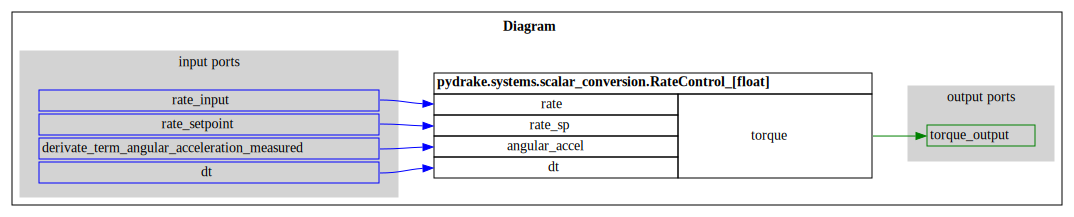

In [13]:
# Instantiate the RateControl system with the default scalar type (double)
RateControl = RateControl_[None]
builder = DiagramBuilder()
rate_control_system = builder.AddSystem(RateControl())

builder.ExportInput(rate_control_system.get_input_port(0), "rate_input")
builder.ExportInput(rate_control_system.get_input_port(1), "rate_setpoint")
builder.ExportInput(rate_control_system.get_input_port(2), "derivate_term_angular_acceleration_measured")
builder.ExportInput(rate_control_system.get_input_port(3), "dt")

builder.ExportOutput(rate_control_system.get_output_port(0), "torque_output")

# Build the diagram
diagram = builder.Build()

display(
    SVG(
        pydot.graph_from_dot_data(
            diagram.GetGraphvizString(
                max_depth=3))[0].create_svg()))

### Part 2 - Attitude Controller

In [36]:
import numpy as np
from pydrake.systems.framework import LeafSystem_, BasicVector_, PublishEvent, TriggerType
from pydrake.systems.scalar_conversion import TemplateSystem
from pydrake.symbolic import if_then_else, Expression

@TemplateSystem.define("AttitudeController_")
def AttitudeController_(T):

    class Impl(LeafSystem_[T]):

        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)
            # Time constant tau
            self.tau = 1
            # Input port for the current attitude quaternion
            self.q_port = self.DeclareVectorInputPort("q", BasicVector_[T](4))
            # Input port for the desired attitude quaternion
            self.q_dmd_port = self.DeclareVectorInputPort("q_dmd", BasicVector_[T](4))
            # Output port for the rate command
            self.DeclareVectorOutputPort("rate_cmd", BasicVector_[T](3), self.CalcOutput)

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def CalcOutput(self, context, output):
            q = self.q_port.Eval(context)
            q_dmd = self.q_dmd_port.Eval(context)
            # Compute the error quaternion
            q_e = self.quaternion_multiply(q_dmd, self.quaternion_conjugate(q))
            sgn_q_e0 = if_then_else(q_e[0] >= 0, Expression(1), Expression(-1))
            # Calculate the command rate
            q_cmd_dot = (-2.0 / self.tau) * sgn_q_e0 * q_e
            output.SetFromVector(q_cmd_dot[1:])

        @staticmethod
        def quaternion_conjugate(q):
            """Compute the conjugate of a quaternion."""
            return np.array([q[0], -q[1], -q[2], -q[3]])

        @staticmethod
        def quaternion_multiply(q1, q2):
            """Multiply two quaternions."""
            w1, x1, y1, z1 = q1
            w2, x2, y2, z2 = q2
            return np.array([
                w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2,
                w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2,
                w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2,
                w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
            ])

    return Impl

# Now instantiate the system with specific parameters
AttitudeController = AttitudeController_[None]  # Could also be e.g. AutoDiffXd
attitude_controller = AttitudeController()


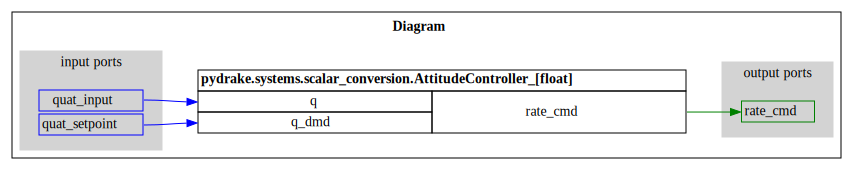

In [38]:
# Instantiate the RateControl system with the default scalar type (double)
AttitudeController = AttitudeController_[np.float64]
builder = DiagramBuilder()
attitude_control_system = builder.AddSystem(AttitudeController())

builder.ExportInput(attitude_control_system.get_input_port(0), "quat_input")
builder.ExportInput(attitude_control_system.get_input_port(1), "quat_setpoint")

builder.ExportOutput(attitude_control_system.get_output_port(0), "rate_cmd")

# Build the diagram
diagram = builder.Build()

display(
    SVG(
        pydot.graph_from_dot_data(
            diagram.GetGraphvizString(
                max_depth=3))[0].create_svg()))

# Linear Quadratic Regulator

## Simplified Dynamics

In [1]:
import numpy as np
from pydrake.all import LeafSystem, BasicVector, PortDataType, AbstractValue, Quaternion, RollPitchYaw
from pydrake.math import RotationMatrix
from pydrake.systems.framework import LeafSystem_, BasicVector_, PublishEvent, TriggerType
from pydrake.systems.scalar_conversion import TemplateSystem
from pydrake.symbolic import if_then_else, Expression
from pydrake.all import DiagramBuilder, Simulator, ConstantVectorSource
from pydrake.systems.primitives import LogVectorOutput


@TemplateSystem.define("QuaternionDynamicsSystem_")
def QuaternionDynamicsSystem_(T):

    class Impl(LeafSystem_[T]):

        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)
            # Declare system state: assuming 10 states as per your dynamics
            self.DeclareContinuousState(10)
            # Input port for control inputs: assuming 4 inputs
            self.DeclareVectorInputPort("u", BasicVector_[T](4))
            # Output port for system state
            self.DeclareVectorOutputPort("x", BasicVector_[T](10), self.CopyStateOut)

        def _construct_copy(self, other, converter=None):
            # Constructor used for scalar conversion
            Impl._construct(self, converter=converter)

        def CopyStateOut(self, context, output):
            # Copy the state to the output port
            x = context.get_continuous_state_vector().CopyToVector()
            output.SetFromVector(x)

        def DoCalcTimeDerivatives(self, context, derivatives):
            x = context.get_continuous_state_vector().CopyToVector()
            u = self.EvalVectorInput(context, 0).CopyToVector()
            # Calculate dynamics here. Placeholder for actual dynamics calculation
            dx_dt = self.calculate_dynamics(x, u)
            derivatives.get_mutable_vector().SetFromVector(dx_dt)
    
        def calculate_dynamics(self, x, u):
            # Extract the state components
            p = x[:3]  # Position (px, py, pz)
            q = x[3:7]  # Orientation quaternion (qw, qx, qy, qz)
            v = x[7:]  # Velocity (vx, vy, vz)
        
            # Extract control inputs
            omega_des = u[:3]  # Desired body rates (wx_des, wy_des, wz_des)
            c_des = u[3]  # Desired thrust
        
            # Construct the quaternion from state
            q_w, q_x, q_y, q_z = q
        
            # Quaternion kinematics
            Qx = np.array([
                [ q_w, -q_x, -q_y, -q_z],
                [ q_x,  q_w, -q_z,  q_y],
                [ q_y,  q_z,  q_w, -q_x],
                [ q_z, -q_y,  q_x,  q_w]
            ])

            augmented_omega = np.concatenate(([0], omega_des)).reshape(4,)
            # Quaternion derivative
            q_dot = 0.5 * Qx @ augmented_omega
        
            # Compute the gravity vector
            g = 9.81  # Acceleration due to gravity
            g_vec = np.array([0, 0, -g])
        
            # Rotation matrix from quaternion
            R = np.array([
                [1 - 2*q_y**2 - 2*q_z**2, 2*q_x*q_y - 2*q_z*q_w,     2*q_x*q_z + 2*q_y*q_w],
                [2*q_x*q_y + 2*q_z*q_w,     1 - 2*q_x**2 - 2*q_z**2, 2*q_y*q_z - 2*q_x*q_w],
                [2*q_x*q_z - 2*q_y*q_w,     2*q_y*q_z + 2*q_x*q_w,     1 - 2*q_x**2 - 2*q_y**2]
            ])
        
            # Velocity dynamics
            v_dot = g_vec + R @ np.array([0, 0, c_des])
            dx_dt = np.concatenate((v, q_dot, v_dot))
        
            return dx_dt

    return Impl

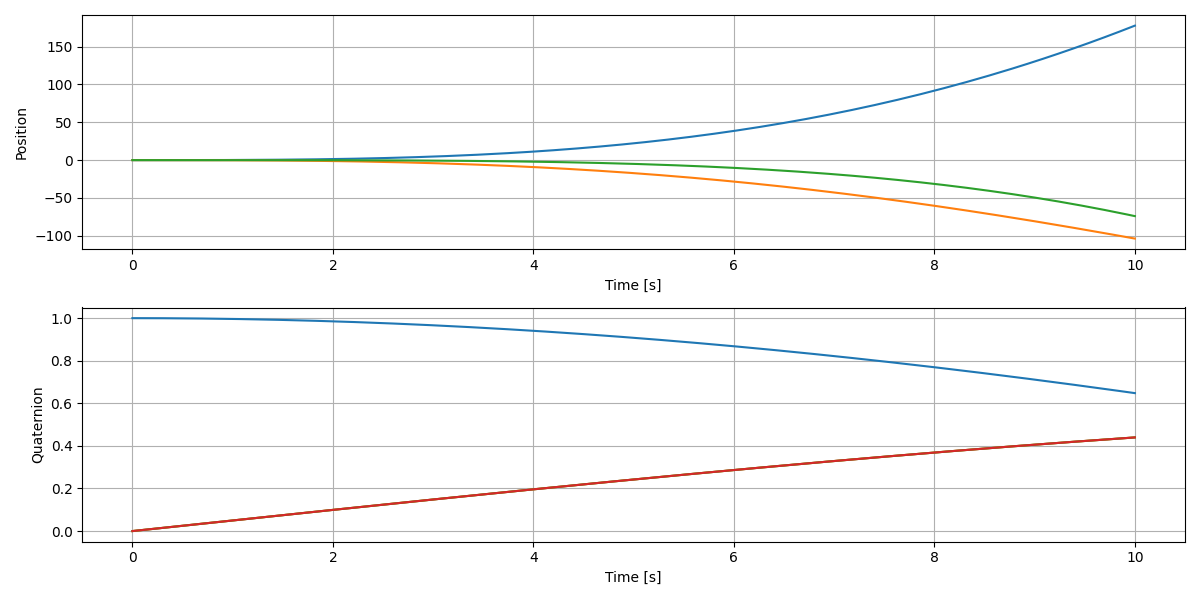

In [11]:
# Create the system

Dynamics = QuaternionDynamicsSystem_[None]
system = Dynamics()

# Define initial conditions
initial_state = np.array([0, 0, 0,  # Initial position
                          1, 0, 0, 0,  # Initial orientation (Identity quaternion)
                          0, 0, 0])  # Initial velocity

# Define a simple control input trajectory (constant for this example)
control_input = np.array([0.1, 0.1, 0.1,  # Constant body rates
                          9.81])  # Thrust to counteract gravity

# Create a diagram to manage the system and the log
builder = DiagramBuilder()
system_instance = builder.AddSystem(system)

# Add a constant source for control inputs
control_source = builder.AddSystem(ConstantVectorSource(control_input))
builder.Connect(control_source.get_output_port(0), system_instance.get_input_port(0))

# Add logger to capture the output
logger = LogVectorOutput(system_instance.get_output_port(0), builder)

# Build the diagram
diagram = builder.Build()

# Create a simulator and set initial conditions
simulator = Simulator(diagram)
simulator_context = simulator.get_mutable_context()
simulator_context.SetContinuousState(initial_state)

# Simulate for a given duration
duration = 10  # seconds
simulator.AdvanceTo(duration)

# Retrieve and plot the logged data
import matplotlib.pyplot as plt

log_data = logger.FindLog(simulator_context)
time = log_data.sample_times()
state = log_data.data()

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, state[:3, :].T)  # Plot position
plt.xlabel('Time [s]')
plt.ylabel('Position')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time, state[3:7, :].T)  # Plot quaternion components
plt.xlabel('Time [s]')
plt.ylabel('Quaternion')
plt.grid(True)

plt.tight_layout()
plt.show()

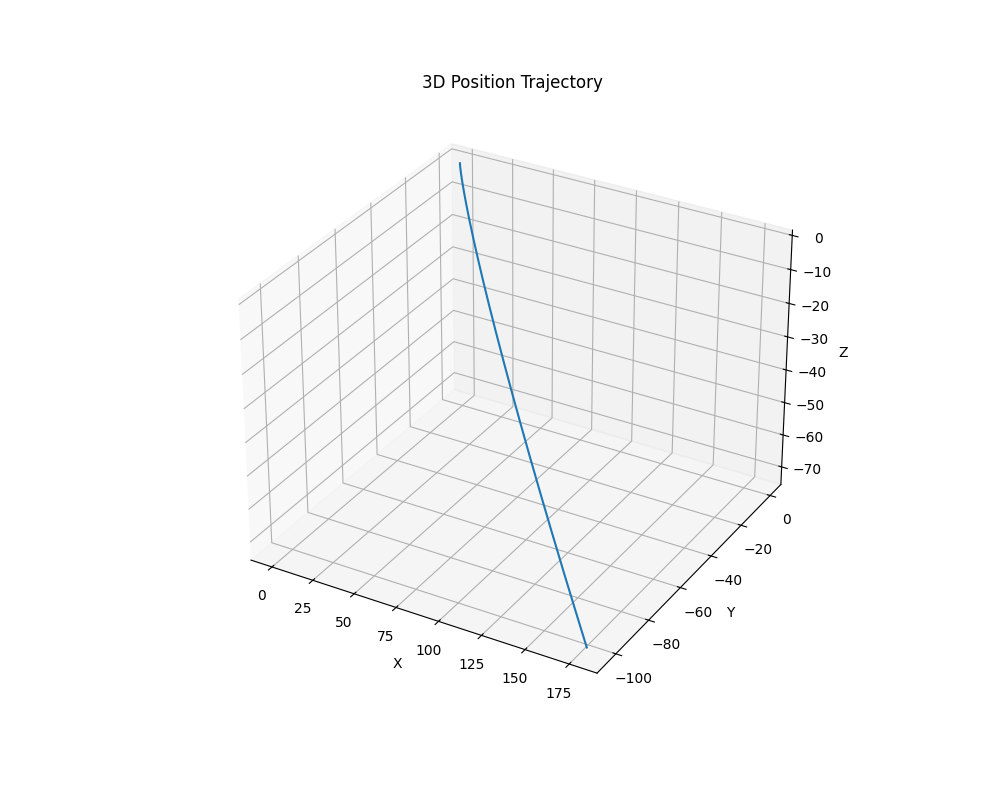

In [12]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting module

# Assuming 'state' contains the 3D position data in its first three rows
# and 'time' contains the sample times, you can retrieve this data as before
# Here, I'm assuming that 'logger' and 'simulator_context' are defined elsewhere in your code

# Retrieve and plot the logged data
log_data = logger.FindLog(simulator_context)
# Assuming 'state' is structured as [x_position, y_position, z_position, ...other states]
state = log_data.data()

# Plotting just the 3D position trajectory
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# Create a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D position trajectory
ax.plot(state[0, :], state[1, :], state[2, :])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Position Trajectory')
ax.grid(True)  # Enable the grid for better visualization

plt.show()


In [13]:
T = float  # Use float for a continuous system
system = QuaternionDynamicsSystem_[T]()

# Create a default context
context = system.CreateDefaultContext()

# Set state: [position (0, 0, 0), orientation (1, 0, 0, 0) as quaternion, velocity (0, 0, 0)]
state_vector = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])  # Example state
context.SetContinuousState(state_vector)

# Set input: [desired body rates (0, 0, 0), desired thrust for gravity compensation]
input_vector = np.array([0, 0, 0, 9.81])  # Example input for gravity compensation
system.get_input_port(0).FixValue(context, input_vector)

In [14]:
from pydrake.systems.primitives import Linearize

# Linearize the system around the operating point
linear_system = Linearize(system, context)


In [15]:
def matrix_to_latex(matrix, name="A"):
    """Convert a NumPy matrix to a LaTeX representation."""
    latex_str = f"{name} = \\begin{{bmatrix}}"
    for i in range(matrix.shape[0]):
        row_str = " & ".join(f"{matrix[i, j]:.4f}" for j in range(matrix.shape[1]))
        latex_str += row_str
        if i < matrix.shape[0] - 1:
            latex_str += "\\\\"
    latex_str += "\\end{bmatrix}"
    return latex_str


In [16]:
from IPython.display import display, Latex
A_matrix = linear_system.A()
B_matrix = linear_system.B()

# Assuming A_matrix and B_matrix are already defined as the A and B matrices from your linear system

# Convert matrices to LaTeX strings
A_latex = matrix_to_latex(A_matrix, "A")
B_latex = matrix_to_latex(B_matrix, "B")

# Display matrices in LaTeX format
display(Latex(A_latex))
display(Latex(B_latex))



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

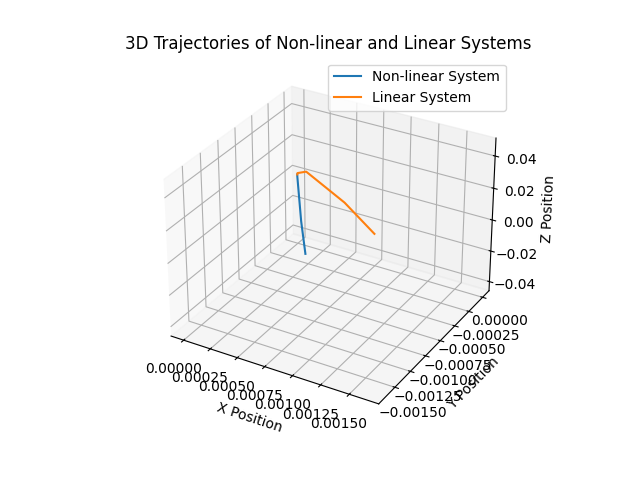

In [19]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import (DiagramBuilder, Simulator,
                         Linearize, ConstantVectorSource)

from pydrake.all import LogVectorOutput as LogOutput
from pydrake.systems.primitives import Linearize


# Assuming QuaternionDynamicsSystem_ is already defined in your environment
# and has a method or output port that provides the 3D position
T = float  # Use float for a continuous system
system = QuaternionDynamicsSystem_[T]()

# Create a default context
context = system.CreateDefaultContext()

# Define the initial state for the quaternion dynamics system
# [position (0, 0, 0), orientation quaternion (1, 0, 0, 0), velocity (0, 0, 0)]
initial_state = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

# Define the initial control input (actuation)
# [desired body rates (0, 0, 0), desired thrust (0)]
initial_input = np.array([0, 0, 0, 9.81])

# Set the initial condition for the system's context
context.get_mutable_continuous_state_vector().SetFromVector(initial_state)

# Fix the input port to the initial control input
system.get_input_port(0).FixValue(context, initial_input)

# Now you can linearize the system around the initial state and input
linearized_system = Linearize(system, context)
# Create two separate diagram builders for non-linear and linear systems
builder_non_linear = DiagramBuilder()
non_linear_system = builder_non_linear.AddSystem(system)
logger_non_linear = LogOutput(non_linear_system.get_output_port(0), builder_non_linear)

builder_linear = DiagramBuilder()
linear_system = builder_linear.AddSystem(linearized_system)
logger_linear = LogOutput(linear_system.get_output_port(0), builder_linear)

# Connect a constant vector source to provide input to the systems
input_source_non_linear = builder_non_linear.AddSystem(ConstantVectorSource(np.ones(4)))
builder_non_linear.Connect(input_source_non_linear.get_output_port(0), non_linear_system.get_input_port(0))

input_source_linear = builder_linear.AddSystem(ConstantVectorSource(np.array([1, 1, 1, 9.81])))
builder_linear.Connect(input_source_linear.get_output_port(0), linear_system.get_input_port(0))

# Build the diagrams and create simulators
diagram_non_linear = builder_non_linear.Build()
simulator_non_linear = Simulator(diagram_non_linear)

diagram_linear = builder_linear.Build()
simulator_linear = Simulator(diagram_linear)

# Set the initial state for each simulation
context_non_linear = simulator_non_linear.get_mutable_context()
context_non_linear.SetContinuousState(initial_state)

context_linear = simulator_linear.get_mutable_context()
context_linear.SetContinuousState(initial_state)

# Simulate both systems
simulation_time = 0.1  # Specify simulation duration
simulator_non_linear.AdvanceTo(simulation_time)
simulator_linear.AdvanceTo(simulation_time)

# Step 5: Retrieve logged positions
logger_non_linear_data = logger_non_linear.FindLog(context_non_linear)
logger_linear_data = logger_linear.FindLog(context_linear)
non_linear_positions = logger_non_linear_data.data()
linear_positions = logger_linear_data.data()

# Extract 3D positions (assuming the first three states are 3D positions)
# This will depend on your system's specific state representation
non_linear_3d_positions = non_linear_positions[:3, :]
linear_3d_positions = linear_positions[:3, :]

# Plot the trajectories
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot non-linear system trajectory
ax.plot(non_linear_3d_positions[0, :], non_linear_3d_positions[1, :], non_linear_3d_positions[2, :], label='Non-linear System')

# Plot linear system trajectory
ax.plot(linear_3d_positions[0, :], linear_3d_positions[1, :], linear_3d_positions[2, :], label='Linear System')

# Label the axes
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('3D Trajectories of Non-linear and Linear Systems')
ax.legend()

# Show the plot
plt.show()


## Robustness to Disturbances

In [27]:
def MultibodyQuadrotorLQR():
    quadrotor_diagram, quadrotor_plant = MakeMultibodyQuadrotor()

    # Create the LQR controller
    context = quadrotor_diagram.CreateDefaultContext()
    nominal_state = context.get_continuous_state_vector().CopyToVector()
    print(nominal_state)
    nominal_state[2] = 2.0  # Set the z position to 1.0m
    context.SetContinuousState(nominal_state)
    
    # Calculate nominal input
    mass = quadrotor_plant.CalcTotalMass(quadrotor_plant.GetMyContextFromRoot(context))
    print(mass)
    gravity = quadrotor_plant.gravity_field().gravity_vector()[2]
    print(gravity)
    nominal_input = [(-mass * gravity) / 4] * 4
    #nominal_input = [0, 0, 0, 0]

    print(nominal_input)
    
    # Fix the input port value
    quadrotor_diagram.get_input_port().FixValue(context, nominal_input)
    
    # Define Q and R matrices for LQR
    Q = np.diag(np.concatenate(([10] * 6, [1] * 6)))
    R = np.eye(4)
    
    # Create the LQR controller diagram
    controller_diagram = LinearQuadraticRegulator(quadrotor_diagram, context, Q, R)

    return quadrotor_diagram, controller_diagram



In [28]:
quadrotor, controller = MultibodyQuadrotorLQR()

quadrotor.set_name("quadrotor_dynamics")
controller.set_name("LQR_Controller")
# Simulate the system
builder = DiagramBuilder()
builder.AddSystem(quadrotor)
builder.AddSystem(controller)
builder.Connect(controller.get_output_port(), quadrotor.get_input_port())  # Connect the controller output to the quadrotor input
builder.Connect(quadrotor.get_output_port(), controller.get_input_port())
diagram = builder.Build()

diagram.set_name("closed-loop-system")


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.5970469
-9.81
[1.4642575222500003, 1.4642575222500003, 1.4642575222500003, 1.4642575222500003]


RuntimeError: The nominal operating point (x0,u0) is not an equilibrium point of the system.  Without additional information, a time-invariant linearization of this system is not well defined.

### View LQR Diagram

In [18]:
display(
    SVG(
        pydot.graph_from_dot_data(
            controller.GetGraphvizString())[0].create_svg()))

NameError: name 'controller' is not defined

#### View Simplified Diagram

In [ ]:
display(
    SVG(
        pydot.graph_from_dot_data(
            diagram.GetGraphvizString(
                max_depth=1))[0].create_svg()))

#### View Detailed Diagram

In [ ]:
display(
    SVG(
        pydot.graph_from_dot_data(
            diagram.GetGraphvizString(
                max_depth=4))[0].create_svg()))

In [37]:
def initialize_simulation(diagram):
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.)
    return simulator

def run_simulation(sim_time_step, finish_time, diagram):
    simulator = initialize_simulation(diagram)
    meshcat.StartRecording()
    simulator.AdvanceTo(finish_time)
    meshcat.PublishRecording()

run_simulation(0.1, 30, diagram)